# Linear Model MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of an MCMC algorithm applied to a simple linear model.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed, widgets
# visulisation function
sys.path.append('/project')
from functions.visualisations import (
    histogram_trace, plot_linear_data,
    plot_y_timeseries, boxplot_weights,
    plot_ycorr_scatter
)
from tqdm import tqdm
from types import MethodType

np.random.seed(2023)

## Define a class with the functions and attributes required for a linear model

- `predict`: Function to output y given the input data and model parameters - $y = w x + b$
- `evaluate_proposal`: Function to load a given proposal distribution ($\theta$) and return the model prediction
- `encode`: Helper function to encode the model parameters ($\theta$) into the model as $w$ and $b$

In [3]:
from models.linear_model import LinearModel
from models.mcmc import MCMC_Linear as MCMC

## Load the data
- Load in the suspot data
- You can also load in the other regeression datasets `Lazer` and `Energy`

In [4]:
# load the data
name        = "Iris"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))

Training data shape: (105, 5)


## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [5]:
# n_samples = 100000 # number of samples to draw from the posterior
# burn_in = 50000 # number of samples to discard before recording draws from the posterior

# thin_factor = 10

# single trace
n_samples = 500000 # number of samples to draw from the posterior
burn_in = 100000 # number of samples to discard before recording draws from the posterior

thin_factor = 50

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

if name in ['Sunspot','Abalone']:
    layer_sizes = [x_data.shape[1], 1]
    data_case = 'regression'
elif name in ['Iris']:
    layer_sizes = [x_data.shape[1], 3]
    data_case = 'classification'
elif name in ['Ionosphere']:
    layer_sizes = [x_data.shape[1], 2]
    data_case = 'classification'
else:
    raise ValueError('data_case is invalid.')

thinned_res = []

## MCMC Settings and Setup
for this_chain in np.arange(1):
    print('Chain: {}'.format(this_chain))
    np.random.seed(2023 + this_chain)
    # Initialise the MCMC class
    lm = LinearModel(layer_sizes=layer_sizes,data_case=data_case)
    mcmc = MCMC(lm,n_samples, burn_in, x_data, y_data, x_test, y_test)
    # Run the sampler
    results, pred = mcmc.sampler()
    # thin to remove autocorrelation and to reduce the size of the data 
    results = results.iloc[::thin_factor,:]
    for _ in pred.keys():
        pred[_] = pred[_][::thin_factor,:]

    thinned_res.append(results)

Chain: 0


  0%|          | 0/499999 [00:00<?, ?it/s]

100%|██████████| 499999/499999 [05:35<00:00, 1491.53it/s]


83.916% were accepted


In [6]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

## Analyse the results
Plot the data with the mean linear fit and some uncertainty.

Plot the posterior distribution and trace for each parameter using ipywidgets.

In [7]:
def plot_hist(results, param_name):
    # results = results_rmse
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)
None

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
sns.set_style('ticks')

# Now plot posterior distribution and trace plot for selected parameters
def plot_posterior(results_in,this_model, this_data, this_param, save_dir=None):
    '''
    Plot the posterior as a histogram and then the traceplot
    '''
    plot_data = results_in[this_param]
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # add light gray grid
    ax.grid(color='xkcd:light grey',alpha=0.7)
    # plot the posterior distribution
    sns.histplot(plot_data.values, ax=ax, bins=20, edgecolor='xkcd:dark grey', linewidth=1.5)
    ax.set_xlabel('Parameter Value', labelpad=10)
    ax.set_ylabel('Frequency', labelpad=10)
    ax.set_title('Posterior distribution', pad=10)
    fig.tight_layout()

    
    # plot the trace plot
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    # add light gray grid
    ax1.grid(color='xkcd:light grey',alpha=0.7)
    sns.lineplot(x=np.arange(plot_data.shape[0]),y=plot_data.values,ax=ax1)
    ax1.set_xlabel('Samples', labelpad=10)
    ax1.set_ylabel('Parameter Value', labelpad=10)
    ax1.set_title('Trace plot', pad=10)


    fig1.tight_layout()
    
    if not save_dir is None:
        fig.savefig(os.path.join(save_dir,'{}_{}_{}_posterior.pgf'.format(this_model,this_data,this_param)))
        fig1.savefig(os.path.join(save_dir,'{}_{}_{}_trace.pgf'.format(this_model,this_data,this_param)))


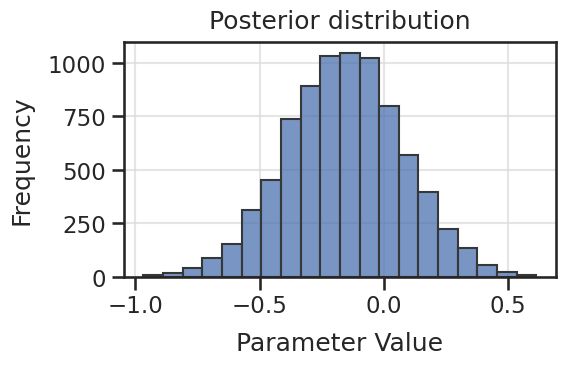

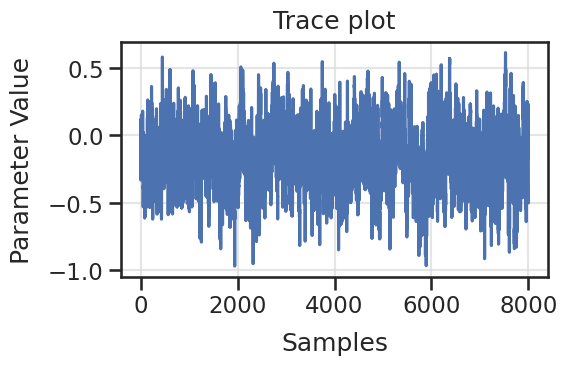

In [9]:
results_dir = os.path.join('publication_results','results')
fig_dir = os.path.join(
    results_dir,
    'figures',
    'posterior'
)
os.makedirs(fig_dir, exist_ok=True)

plot_posterior(results,'linear_tp',name,'w5',save_dir=fig_dir)

# No thinning example

In [10]:
# load the data
name        = "Sunspot"
train_data   = np.loadtxt("data/{}/train.txt".format(name))
test_data    = np.loadtxt("data/{}/test.txt".format(name))

print('Training data shape: {}'.format(train_data.shape))

Training data shape: (298, 5)


In [11]:
# single trace
n_samples = 25000 # number of samples to draw from the posterior
burn_in = 5000 # number of samples to discard before recording draws from the posterior

thin_factor = 1

# or load from sunspot data
x_data = train_data[:,:-1]
y_data = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

if name in ['Sunspot','Abalone']:
    layer_sizes = [x_data.shape[1], 1]
    data_case = 'regression'
elif name in ['Iris']:
    layer_sizes = [x_data.shape[1], 3]
    data_case = 'classification'
elif name in ['Ionosphere']:
    layer_sizes = [x_data.shape[1], 2]
    data_case = 'classification'
else:
    raise ValueError('data_case is invalid.')

## MCMC Settings and Setup
np.random.seed(2023)
# Initialise the MCMC class
lm = LinearModel(layer_sizes=layer_sizes,data_case=data_case)
mcmc = MCMC(lm,n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results_nothin, pred = mcmc.sampler()
# thin to remove autocorrelation and to reduce the size of the data 
results_nothin = results_nothin.iloc[::thin_factor,:]
for _ in pred.keys():
    pred[_] = pred[_][::thin_factor,:]


  5%|▌         | 1250/24999 [00:00<00:03, 6110.14it/s]

100%|██████████| 24999/24999 [00:04<00:00, 6046.13it/s]

5.328% were accepted


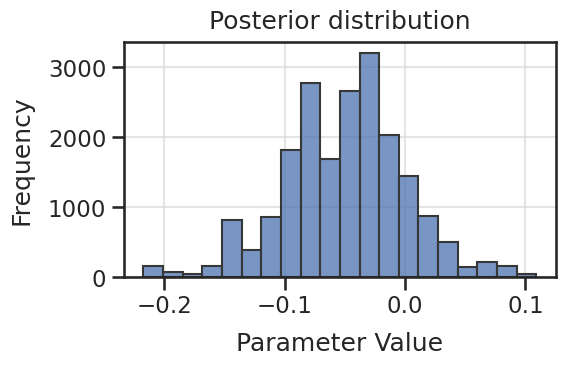

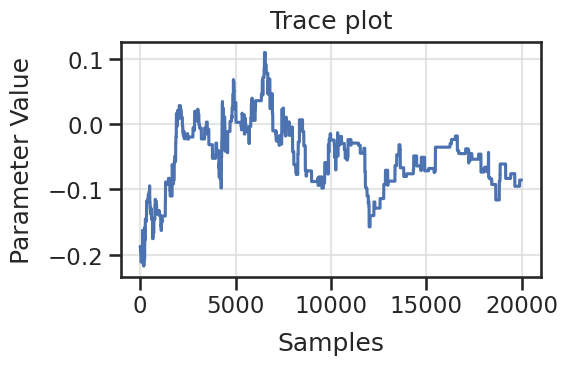

In [12]:
plot_posterior(results_nothin,'linear_tp_nothinning',name,'w0',save_dir=fig_dir)